<a href="https://colab.research.google.com/github/XaviJunior/SBB/blob/master/project_2/Code/Team_SBB_project_2_Tarik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? NLP with Disaster Tweets (Kaggle Competition)

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo("", width=600)

[Link to the GitHub repository](https://github.com/XaviJunior/SBB)

[Link to the YouTube video]()

## Contributions

* **Xavier AEBY**: 
* **Tarik BACHA**: 
* **Tanguy BERGUERAND**: 
* **Frederic SPYCHER**: 

## Introduction

For our second group project, we were tasked with joining the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) Kaggle competition, which consists of devising a machine learning model that can predict, using natural language processing, whether tweets announcing a disaster are genuine or not.

The incentive for such a model is to assist disaster relief organizations and news agencies identify actual   as they monitor Twitter (which is often used as a communication tool during such events).

## Setting things up

In [0]:
!pip install spacy
!pip install xgboost

In [0]:
import re
import string

import numpy as np
import pandas as pd
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

RSEED = 42

## The data

The data provided by Kaggle contains more than **10,000 tweets**, for 70% of which we are given their `target` class (1 = true, 0 = false). Each observation from the training data is composed of an `id` and the `text` of the tweet. In some cases, a `keyword` as well as the tweet's `location` are also given.

In [139]:
df = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/train.csv", encoding="utf-8")
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [140]:
print("Classified observations:", df.shape[0])

Classified observations: 7613


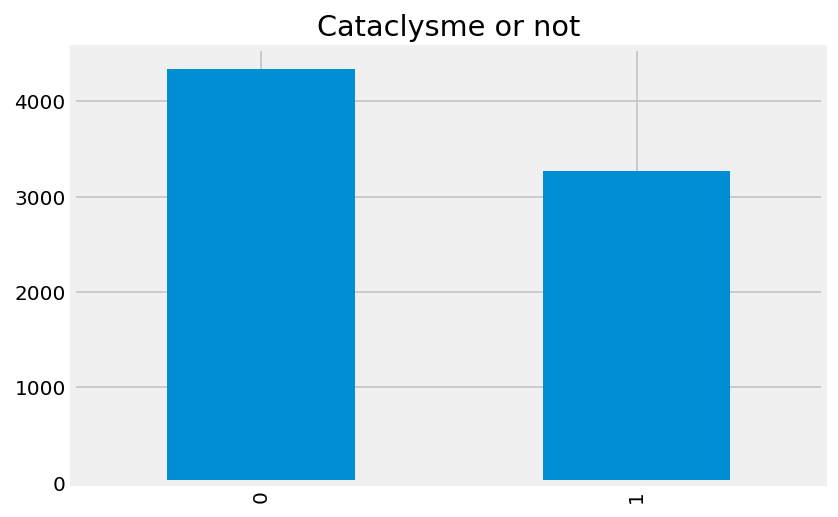

In [156]:
data['target'].value_counts().plot.bar(title = 'Cataclysme or not')
plt.show()

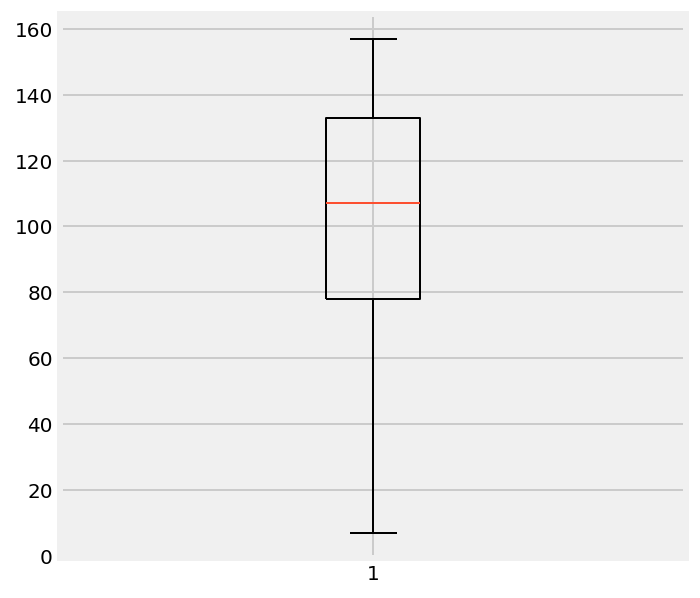

In [142]:
data['pre_clean_len'] = [len(t) for t in data.text]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_clean_len)
plt.show()

In [87]:
df_test = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/test.csv", encoding="utf-8")
df_test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [88]:
print("Unclassified observations:", df_test.shape[0])

Unclassified observations: 3263


In [100]:
len(df_test.text[1])

64

## Cleaning

In [0]:
def clean(tweet):
    tweet = re.sub(r" \w{1,3}\.{3,3} http\S{0,}", " ", tweet) #
    tweet = re.sub(r"http\S{0,}", " ", tweet) #
    tweet = re.sub(r".Û.", "", tweet) #
    tweet = re.sub(r"\s+", " ", tweet) #
    tweet = re.sub(r'\t', " ", tweet) #
    tweet = re.sub(r'\n', " ", tweet) #
    tweet = re.sub(r"\.{3,3}", "", tweet) #
    tweet = re.sub("[^a-zA-Z]", " ", tweet) #remove the "#""

    return tweet
    
df["text"] = df["text"].apply(clean)
df_test["text"] = df_test["text"].apply(clean)

# df["text"].to_csv("tweets.csv", index=False)

## DataViz

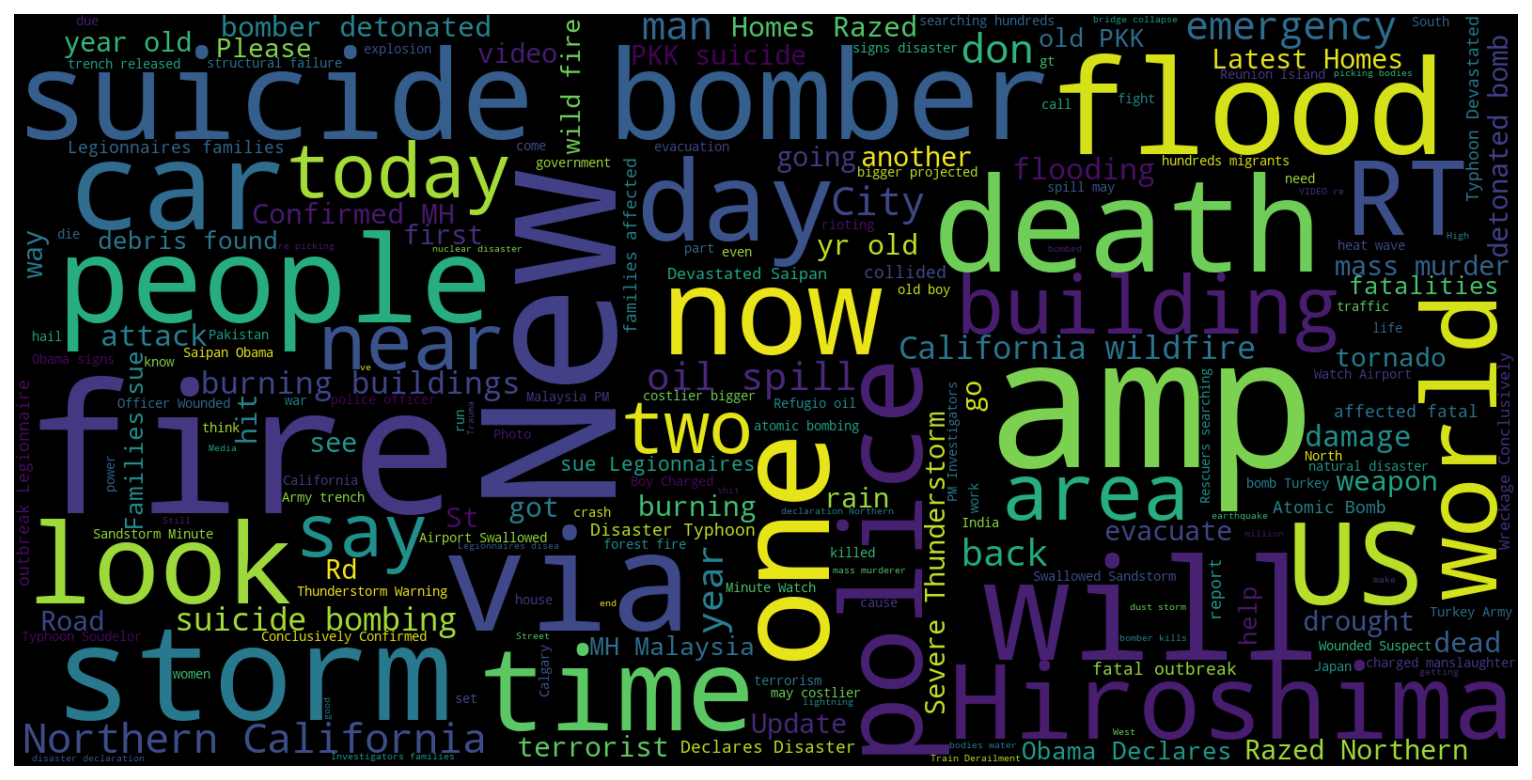

In [159]:
from wordcloud import WordCloud
Cata_stringT = []
Cata_stringT=[t for t in tweets_Cata.text]
Cata_string = pd.Series(Cata_stringT).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(Cata_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [178]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(ngram_range=(2,2))
cvec.fit(df["text"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [179]:
print("number of feature identify by the CountVectorizer =",len(cvec.get_feature_names()))

number of feature identify by the CountVectorizer = 59419


In [0]:
#crée un df qui sum le nombre d'apparition de chaine de caractère !
def token_counter(df, minGram, maxGram):
  from sklearn.feature_extraction.text import CountVectorizer
  minGram = minGram
  maxGram = maxGram
  df = df
  cvec = CountVectorizer(ngram_range=(minGram,maxGram), stop_words='english')
  cvec.fit(df["text"])
  NoCata_doc_matrix = cvec.transform(df[df["target"] == 0].text)
  Cata_doc_matrix = cvec.transform(df[df["target"] == 1].text)
  NoCata_tf = np.sum(NoCata_doc_matrix,axis=0)
  Cata_tf = np.sum(Cata_doc_matrix,axis=0)
  NoCata = np.squeeze(np.asarray(NoCata_tf))
  Cata = np.squeeze(np.asarray(Cata_tf))
  term_freq_df = pd.DataFrame([NoCata,Cata],columns=cvec.get_feature_names()).transpose()
  term_freq_df.columns = ['Nothing', 'Disaster']
  term_freq_df['total'] = term_freq_df['Nothing'] + term_freq_df['Disaster']
  return term_freq_df
#term_freq_df.head()

In [0]:
dfViz = pd.DataFrame()
dfViz = token_counter(df,2,2)

In [200]:
dfViz.sort_values(by='total', ascending=False).iloc[:10]

,Nothing,Disaster,total
suicide bomber,0,59,59
burning buildings,23,36,59
youtube video,36,7,43
liked youtube,35,7,42
northern california,0,41,41
cross body,39,1,40
oil spill,1,38,39
suicide bombing,1,35,36
year old,6,28,34
california wildfire,0,34,34


## Tokenization

In [0]:
nlp = English()
punctuation = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(tweet):
    tokens = nlp(tweet)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    
    return tokens

#vectorizer = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,1))
vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,1))

## Training models

For our first attempts at building a model, we went back to models previously seen in the Data Mining & Machine Learning and Big-Scale Analytics courses, without tweaking the hyperparamaters too much, in order to compare how they each perform with this particular dataset.

Preparing the data: needs to be in the form of the list

In [149]:
X = vectorizer.fit_transform(df["text"].values.tolist())
y = df["target"].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

X_train

<6090x15973 sparse matrix of type '<class 'numpy.int64'>'
	with 52046 stored elements in Compressed Sparse Row format>

In [0]:
# vectorizer.get_feature_names()

### Random forest

In [131]:
RF = RandomForestClassifier(criterion="entropy", n_estimators=30, max_depth=200, random_state=RSEED)
RF.fit(X_train, y_train)
f1_score(y_test, RF.predict(X_test)) #0.6904 // #sans ponctuation:0.7125000000000001 // #fullLowerCase_SansPonctuation:0.7125000000000001

0.7125000000000001

### XGBoost

In [132]:
xgc = xgb.XGBClassifier(n_estimators=101, max_depth=71, base_score=0.5, objective='binary:logistic', random_state=RSEED)
xgc.fit(X_train, y_train)
f1_score(y_test, xgc.predict(X_test)) #0.73411 // #sans ponctuation:0.7376 // #fullLowerCase_SansPonctuation:0.737611

0.7376116978066614

### Neural network

### Logistic Regression

In [133]:
LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
f1_score(y_test, LR.predict(X_test)) #0.746908 (base) // #sans ponctuation:0.7504 // #fullLowerCase_SansPonctuation:0.750413223140496

0.750413223140496

## Exporting predictions

In [0]:
To send our submissions for the Kaggle competition, we compute predictions for a set of tweets provided by the website and send them in a CSV file containing the tweet `id` and the predicted `target` 

In [0]:
X = vectorizer.transform(df_test["text"].values.tolist())
df_test["target"] = LR.predict(X)  # modify with appropriate model

df_test[["id", "target"]].to_csv("UNIL_SBB_FSP.csv", index=False)

## Unused code

In [107]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline
text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf',MultinomialNB()),])

text_clf.fit(Text_train, y_train)
print(text_clf.score(Text_test,y_test))

0.5653315824031516


In [108]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import layers

input_dim = bow_train.shape[1] 
model = Sequential()
model.add(layers.Dense(600, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(200))
model.add(layers.Dense(150))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [0]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               11014800  
_________________________________________________________________
dense_2 (Dense)              (None, 200)               120200    
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 11,166,671
Trainable params: 11,166,671
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(bow_train, y_train, epochs=10, batch_size=50)
loss, accuracy = model.evaluate(bow_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy)) #0.7525

Epoch 1/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.6881 - accuracy: 0.5576
Epoch 2/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.5235 - accuracy: 0.7635
Epoch 3/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.2059 - accuracy: 0.9320
Epoch 4/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.1203 - accuracy: 0.9553
Epoch 5/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0826 - accuracy: 0.9695
Epoch 6/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0561 - accuracy: 0.9796
Epoch 7/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.0418 - accuracy: 0.9841
Epoch 8/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0349 - accuracy: 0.9857
Epoch 9/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.0290 - accuracy: 0.9882
Epoch 10/10
6090/6090 [==============================] - 22s 4ms/step - l

In [112]:
loss, accuracy = model.evaluate(bow_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5102
